In [1]:
import sys,os,glob,copy
sys.path.append('../')
import numpy as np
from numpy.linalg import norm
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.interpolate import LinearNDInterpolator,interp2d
import matplotlib as mpl
from matplotlib.colors import LogNorm
from IPython.display import display, Markdown
from collections import OrderedDict
import pylhe
import glob
import pyslha

delphesDir = os.path.abspath("/home/camila/MG5/Delphes")
os.environ['ROOT_INCLUDE_PATH'] = os.path.join(delphesDir,"external")

import ROOT
import xml.etree.ElementTree as ET


ROOT.gSystem.Load(os.path.join(delphesDir,"libDelphes.so"))

ROOT.gInterpreter.Declare('#include "classes/SortableObject.h"')
ROOT.gInterpreter.Declare('#include "classes/DelphesClasses.h"')
ROOT.gInterpreter.Declare('#include "external/ExRootAnalysis/ExRootTreeReader.h"')

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution


#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.colormaps.get_cmap('RdYlBu')

Welcome to JupyROOT 6.26/10


In [94]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

### Set delphes files

In [2]:
inputFiles = {'$\Gamma=0.001$': '/home/camila/MonoXSMS/Tests/DMSimp_axial_1j_widths/Events/run_05/axial_2000_1_delphes_events.root',
              '$\Gamma=0.05$': '/home/camila/MonoXSMS/Tests/DMSimp_axial_1j_widths/Events/run_06/axial_2000_1_delphes_events.root',
              '$\Gamma=0.5$': '/home/camila/MonoXSMS/Tests/DMSimp_axial_1j_widths/Events/run_07/axial_2000_1_delphes_events.root'
              }

### Load Model Parameters

In [3]:
parameters = {}
for label,file in inputFiles.items():
    banner = list(glob.glob(os.path.dirname(file)+'/*banner.txt'))
    if len(banner) != 1:
        print('%i banner files found for %s!' %(len(banner),label))
        break
    else:
        banner = banner[0]
    xtree = ET.parse(banner)
    xroot = xtree.getroot()
    xsecPB = eval(xroot.find('init').text.split()[-2])
    slha = xroot.find('header').find('slha').text
    pars = pyslha.readSLHA(slha)
    mMed = pars.blocks['MASS'][55]
    mDM = pars.blocks['MASS'][52]
    gVq = pars.blocks['DMINPUTS'][4] # Mediator-quark vector coupling
    gAq = pars.blocks['DMINPUTS'][10] # Mediator-quark axial coupling
    gVx = pars.blocks['DMINPUTS'][2] # Mediator-DM vector coupling
    gAx = pars.blocks['DMINPUTS'][3] # Mediator-DM axial coupling
    parameters[label] = {'xsec(pb)' : xsecPB, 'mMed' : mMed, 'mDM' : mDM, 
                         'gVq' : gVq, 'gAq' : gAq, 'gVx' : gVx, 'gAx' : gAx}
    print(label,': mMed = %1.2f GeV, mDM = %1.2f GeV, cross-section = %1.3e pb' %(mMed,mDM,xsecPB))

$\Gamma=0.001$ : mMed = 2000.00 GeV, mDM = 1.00 GeV, cross-section = 3.891e-03 pb
$\Gamma=0.05$ : mMed = 2000.00 GeV, mDM = 1.00 GeV, cross-section = 2.854e-01 pb
$\Gamma=0.5$ : mMed = 2000.00 GeV, mDM = 1.00 GeV, cross-section = 5.150e-01 pb


### Load events, get parton level and detector level MET

In [4]:
weights = {label : np.array([]) for label in inputFiles}
met = {label : np.array([]) for label in inputFiles}
genMet = {label : np.array([]) for label in inputFiles}
totalweight = {label : 0.0 for label in inputFiles}

    
for label,inputFile in inputFiles.items():

    f = ROOT.TFile(inputFile,'read')
    tree = f.Get("Delphes")
    nevts = tree.GetEntries()
    parameters[label]['Events'] = nevts
    
    for ievt in range(nevts):    
        tree.GetEntry(ievt)        
        weight = tree.Weight.At(1).Weight # Correct weight when using matching
        
        if weight >= 0:
            totalweight[label] += weight

        missingET = tree.MissingET.At(0)
        genMissingET = tree.GenMissingET.At(0)  # USE REAL MISSING ET!
        
        if missingET.MET < 250.:
            continue
        if genMissingET.MET < 250.:
            continue
        
        weights[label] = np.append(weights[label],weight)
        met[label] = np.append(met[label],missingET.MET)
        genMet[label] = np.append(genMet[label],genMissingET.MET)

    f.Close()

### Total cross-sections

In [5]:
for label,w in totalweight.items():
    print(label,'total cross-section = %1.3e pb (%i events)' %(w,parameters[label]['Events']))
colors = {label : sns.color_palette('deep')[i+1] for i,label in enumerate(weights.keys())}  

$\Gamma=0.001$ total cross-section = 2.913e-03 pb (500000 events)
$\Gamma=0.05$ total cross-section = 2.279e-01 pb (500000 events)
$\Gamma=0.5$ total cross-section = 5.368e-01 pb (500000 events)


### Plot MET distributions (generator level)

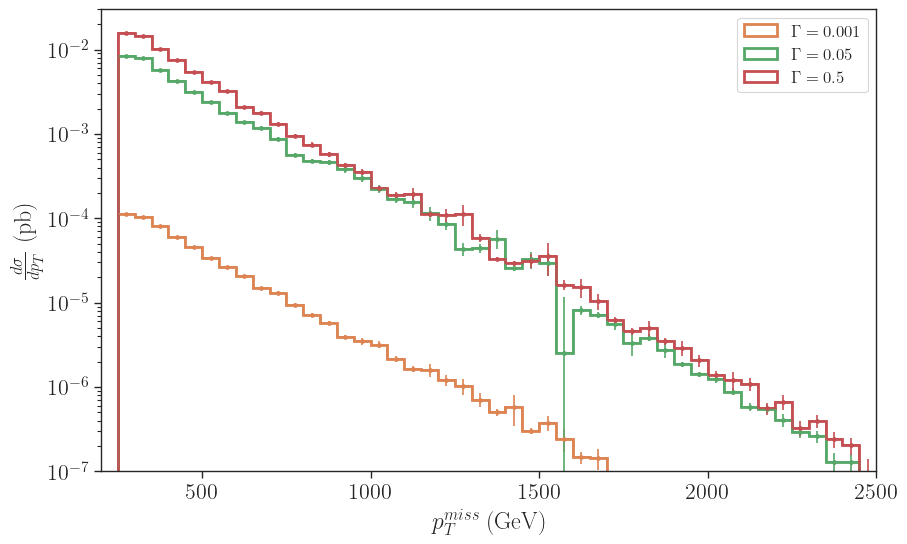

In [6]:
fig = plt.figure(figsize=(10,6))
for label,pt in genMet.items():
    binc,binEdges,patches = plt.hist(pt,bins=np.linspace(0,5000,101),
                               label=label,histtype='step',color=colors[label],
                               weights=weights[label],linewidth=2, density=False)
    errorc2,_ = np.histogram(pt,bins=binEdges,weights=weights[label]**2)
    errorc = np.sqrt(errorc2)
    binCenter = (binEdges[0:-1]+binEdges[1:])/2.
    plt.errorbar(binCenter,binc,yerr = errorc, marker = '.', 
                 drawstyle = 'steps-mid',color=colors[label])

    
plt.yscale('log')
plt.ylim(1e-7,3e-2)
plt.xlabel(r'$p^{miss}_{T}$ (GeV)')
plt.ylabel(r'$\frac{d\sigma}{dp_{T}}$ (pb)')
plt.xlim(200,2500)
plt.legend(loc='upper right', fontsize='x-small')
plt.show()

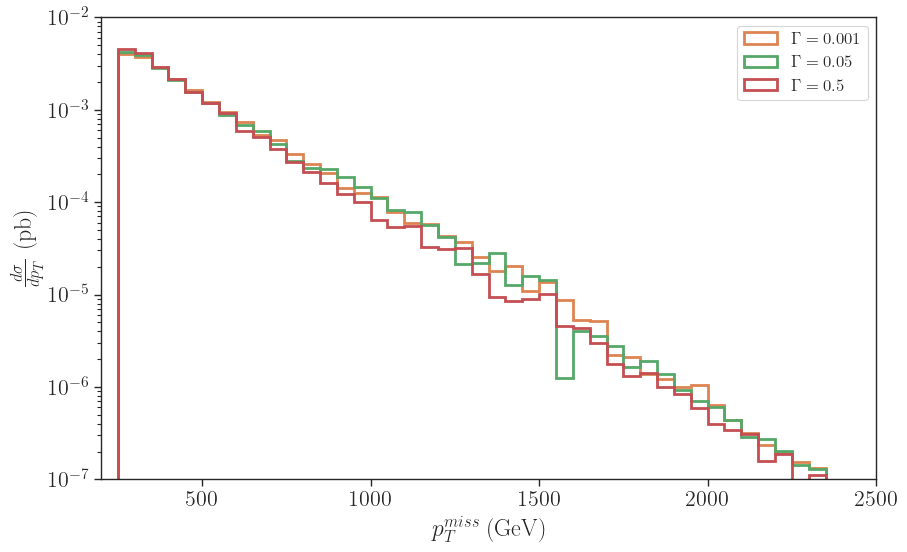

In [7]:
fig = plt.figure(figsize=(10,6))
for label,pt in genMet.items():
    binc,binEdges,patches = plt.hist(pt,bins=np.linspace(0,5000,101),
                               label=label,histtype='step',color=colors[label],
                               weights=weights[label],linewidth=2, density=True)

    
plt.yscale('log')
plt.ylim(1e-7,1e-2)
plt.xlabel(r'$p^{miss}_{T}$ (GeV)')
plt.ylabel(r'$\frac{d\sigma}{dp_{T}}$ (pb)')
plt.xlim(200,2500)
plt.legend(loc='upper right', fontsize='x-small')
plt.show()

/tmp/ipykernel_501688/2706748692.py:27: RuntimeWarning: divide by zero encountered in divide
  ratio1 = (1/k1)*binc001/binc05
/tmp/ipykernel_501688/2706748692.py:27: RuntimeWarning: invalid value encountered in divide
  ratio1 = (1/k1)*binc001/binc05
/tmp/ipykernel_501688/2706748692.py:28: RuntimeWarning: invalid value encountered in multiply
  ratioErr1 = np.sqrt(binc001**2 + ratio1**2 * binc05**2)/binc05
/tmp/ipykernel_501688/2706748692.py:41: RuntimeWarning: divide by zero encountered in divide
  ratio2 = (1/k2)*binc5/binc05
/tmp/ipykernel_501688/2706748692.py:41: RuntimeWarning: invalid value encountered in divide
  ratio2 = (1/k2)*binc5/binc05
/tmp/ipykernel_501688/2706748692.py:42: RuntimeWarning: invalid value encountered in multiply
  ratioErr2 = np.sqrt(binc5**2 + ratio2**2 * binc05**2)/binc05
/tmp/ipykernel_501688/2706748692.py:52: RuntimeWarning: divide by zero encountered in divide
  ratio3 = (1/k3)*binc001/binc5
/tmp/ipykernel_501688/2706748692.py:52: RuntimeWarning: inval

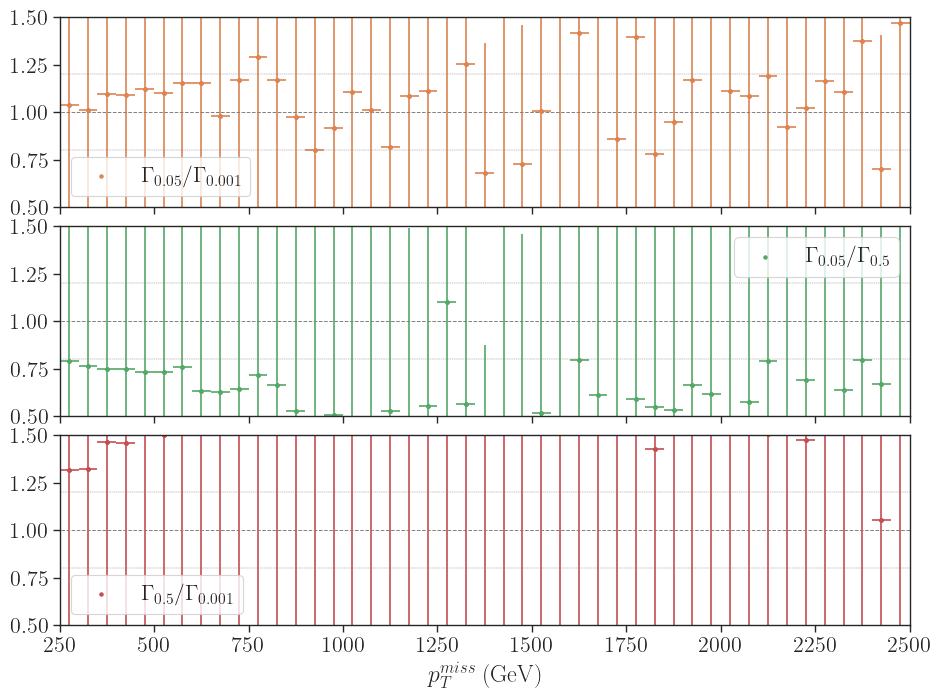

In [8]:
figs, ax = plt.subplots(3,sharex=True,figsize=(10,8))
plt.subplots_adjust(left=0.12, bottom=0.12, right=0.97, top=None, wspace=None, hspace=0.1)

# k=1
k = totalweight['$\\Gamma=0.001$']/totalweight['$\\Gamma=0.05$']

for label,metPts in genMet.items():
    if label in ['$\\Gamma=0.05$']:
        binc05,binEdges = np.histogram(metPts,bins=np.linspace(0,5000,101),
                                         weights=weights[label],density=False)

    
    if label in ['$\\Gamma=0.001$']:
        binc001,binEdges = np.histogram(metPts,bins=np.linspace(0,5000,101),
                                         weights=weights[label],density=False)
        
    if label in ['$\\Gamma=0.5$']:
        binc5,binEdges = np.histogram(metPts,bins=np.linspace(0,5000,101),
                                         weights=weights[label],density=False)


binc001[binc001<0] = 0
binc05[binc05<0] = 0
binc5[binc5<0] = 0

k1 = totalweight['$\\Gamma=0.001$']/totalweight['$\\Gamma=0.05$']
ratio1 = (1/k1)*binc001/binc05
ratioErr1 = np.sqrt(binc001**2 + ratio1**2 * binc05**2)/binc05
binCenter = (binEdges[0:-1]+binEdges[1:])/2.

errorh = (np.diff(binEdges+[2000.])/2).tolist()

ax[0].scatter(binCenter, ratio1, marker='.', label=r'$\Gamma_{0.05}/\Gamma_{0.001}$', 
              color=colors['$\\Gamma=0.001$'])
ax[0].errorbar(binCenter,ratio1,xerr = errorh, yerr=ratioErr1, fmt='.', color=colors['$\\Gamma=0.001$'])
ax[0].hlines(y=1, xmin=0, xmax=2500., linestyle='--', color='gray', linewidth=0.7)
ax[0].hlines(y=1.2, xmin=0, xmax=2500., linestyle='--', color='gray', linewidth=0.3)
ax[0].hlines(y=0.8, xmin=0, xmax=2500., linestyle='--', color='gray', linewidth=0.3)

k2 = totalweight['$\\Gamma=0.5$']/totalweight['$\\Gamma=0.05$']
ratio2 = (1/k2)*binc5/binc05
ratioErr2 = np.sqrt(binc5**2 + ratio2**2 * binc05**2)/binc05

ax[1].scatter(binCenter, ratio2, marker='.', label=r'$\Gamma_{0.05}/\Gamma_{0.5}$', 
              color=colors['$\\Gamma=0.05$'])
ax[1].errorbar(binCenter,ratio2,xerr = errorh, yerr=ratioErr2, fmt='.', color=colors['$\\Gamma=0.05$'])
ax[1].hlines(y=1, xmin=0, xmax=2500., linestyle='--', color='gray', linewidth=0.7)
ax[1].hlines(y=1.2, xmin=0, xmax=2500., linestyle='--', color='gray', linewidth=0.3)
ax[1].hlines(y=0.8, xmin=0, xmax=2500., linestyle='--', color='gray', linewidth=0.3)

k3 = totalweight['$\\Gamma=0.001$']/totalweight['$\\Gamma=0.5$']
ratio3 = (1/k3)*binc001/binc5
ratioErr3 = np.sqrt(binc001**2 + ratio3**2 * binc5**2)/binc5

ax[2].scatter(binCenter, ratio3, marker='.', label=r'$\Gamma_{0.5}/\Gamma_{0.001}$', 
              color=colors['$\\Gamma=0.5$'])
ax[2].errorbar(binCenter,ratio3,xerr = errorh, yerr=ratioErr3, fmt='.', color=colors['$\\Gamma=0.5$'])
ax[2].hlines(y=1, xmin=0, xmax=2500., linestyle='--', color='gray', linewidth=0.7)
ax[2].hlines(y=1.2, xmin=0, xmax=2500., linestyle='--', color='gray', linewidth=0.3)
ax[2].hlines(y=0.8, xmin=0, xmax=2500., linestyle='--', color='gray', linewidth=0.3)

ax[1].set_xlim(250,2500)

ax[0].set_ylim(0.5,1.5)
ax[1].set_ylim(0.5,1.5)
ax[2].set_ylim(0.5,1.5)
ax[2].set_xlabel(r'$p_T^{miss}$ (GeV)')

ax[0].legend()
ax[1].legend()
ax[2].legend()
# plt.savefig('plot-s-ps-bias.png')
plt.show()

### Plot MET distributions (detector level)

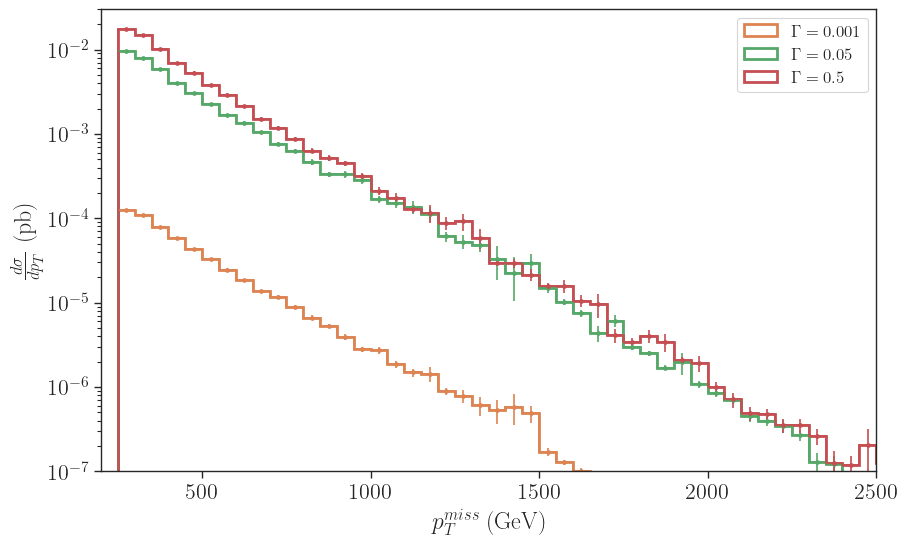

In [9]:
fig = plt.figure(figsize=(10,6))
for label,pt in met.items():
    binc,binEdges,patches = plt.hist(pt,bins=np.linspace(0,5000,101),
                               label=label,histtype='step',color=colors[label],
                               weights=weights[label],linewidth=2, density=False)
    errorc2,_ = np.histogram(pt,bins=binEdges,weights=weights[label]**2)
    errorc = np.sqrt(errorc2)
    binCenter = (binEdges[0:-1]+binEdges[1:])/2.
    plt.errorbar(binCenter,binc,yerr = errorc, marker = '.', 
                 drawstyle = 'steps-mid',color=colors[label])

    
plt.yscale('log')
plt.ylim(1e-7,3e-2)
plt.xlabel(r'$p^{miss}_{T}$ (GeV)')
plt.ylabel(r'$\frac{d\sigma}{dp_{T}}$ (pb)')
plt.xlim(200,2500)
plt.legend(loc='upper right', fontsize='x-small')
plt.show()

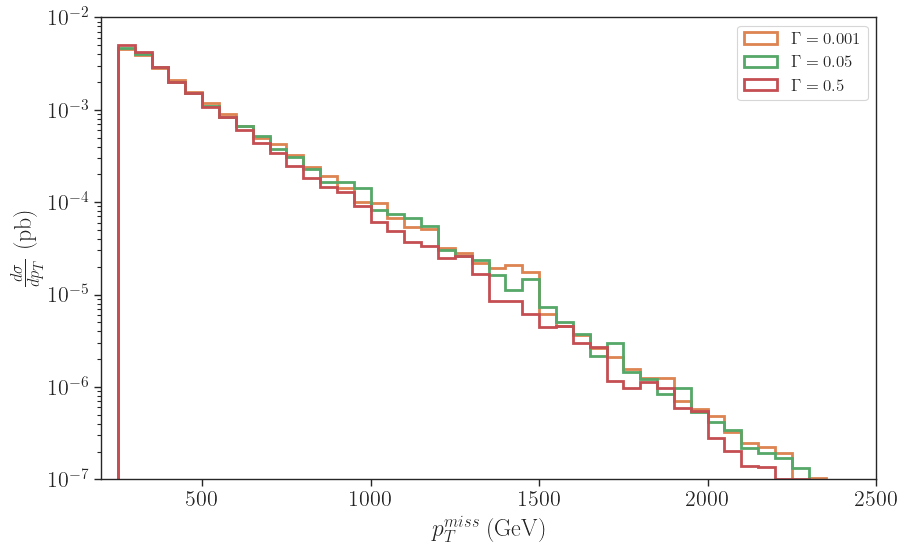

In [10]:
fig = plt.figure(figsize=(10,6))
for label,pt in met.items():
    binc,binEdges,patches = plt.hist(pt,bins=np.linspace(0,5000,101),
                               label=label,histtype='step',color=colors[label],
                               weights=weights[label],linewidth=2, density=True)

    
plt.yscale('log')
plt.ylim(1e-7,1e-2)
plt.xlabel(r'$p^{miss}_{T}$ (GeV)')
plt.ylabel(r'$\frac{d\sigma}{dp_{T}}$ (pb)')
plt.xlim(200,2500)
plt.legend(loc='upper right', fontsize='x-small')
plt.show()

/tmp/ipykernel_501688/15895184.py:24: RuntimeWarning: divide by zero encountered in divide
  ratio1 = k1*binc001/binc05
/tmp/ipykernel_501688/15895184.py:24: RuntimeWarning: invalid value encountered in divide
  ratio1 = k1*binc001/binc05
/tmp/ipykernel_501688/15895184.py:25: RuntimeWarning: invalid value encountered in multiply
  ratioErr1 = np.sqrt(error001**2 + ratio1**2 * error05**2)/error05
/tmp/ipykernel_501688/15895184.py:34: RuntimeWarning: divide by zero encountered in divide
  ratio2 = k2*binc5/binc05
/tmp/ipykernel_501688/15895184.py:34: RuntimeWarning: invalid value encountered in divide
  ratio2 = k2*binc5/binc05
/tmp/ipykernel_501688/15895184.py:35: RuntimeWarning: invalid value encountered in multiply
  ratiorErr2 = np.sqrt(error5**2 + ratio2**2 * error05**2)/error05
/tmp/ipykernel_501688/15895184.py:43: RuntimeWarning: divide by zero encountered in divide
  ratio3 = k3*binc001/binc5
/tmp/ipykernel_501688/15895184.py:43: RuntimeWarning: invalid value encountered in divid

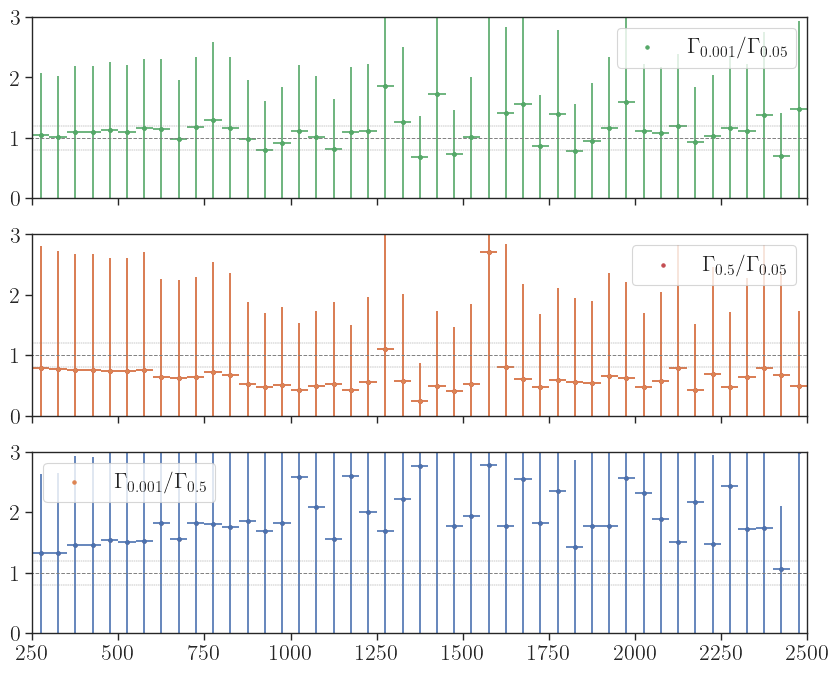

In [89]:
figs, ax = plt.subplots(3,sharex=True,figsize=(10,8))

for label, pt in genMet.items():
    if label in ['$\\Gamma=0.05$']:
        binc05, binEdges = np.histogram(pt, bins=np.linspace(0,5000,101), weights=weights[label], density=False)
        binCenter = (binEdges[0:-1]+binEdges[1:])/2
        error05_2, _ = np.histogram(pt, bins=binEdges, weights=weights[label]**2, density=False)
        error05 = np.sqrt(error05_2)
        
    if label in ['$\\Gamma=0.001$']:
        binc001, binEdges = np.histogram(pt, bins=np.linspace(0,5000,101), weights=weights[label], density=False)
        binCenter = (binEdges[0:-1]+binEdges[1:])/2
        error001_2, _ = np.histogram(pt, bins=binEdges, weights=weights[label]**2, density=False)
        error001 = np.sqrt(error001_2)
        
    if label in ['$\\Gamma=0.5$']:
        binc5, binEdges = np.histogram(pt, bins=np.linspace(0,5000,101), weights=weights[label], density=False)
        binCenter = (binEdges[0:-1]+binEdges[1:])/2
        error5_2, _ = np.histogram(pt, bins=binEdges, weights=weights[label]**2, density=False)
        error5 = np.sqrt(error5_2)     
        
k1 = totalweight['$\\Gamma=0.05$']/totalweight['$\\Gamma=0.001$']
# k1 = 1
ratio1 = k1*binc001/binc05
ratioErr1 = np.sqrt(error001**2 + ratio1**2 * error05**2)/error05
errorh = (np.diff(binEdges+[2000.])/2).tolist()

ax[0].scatter(binCenter, ratio1, marker='.', label=r'$\Gamma_{0.001}/\Gamma_{0.05}$', 
              color=colors['$\\Gamma=0.05$'])
ax[0].errorbar(binCenter, ratio1, xerr=errorh, yerr=ratioErr1, fmt='.', color=colors['$\\Gamma=0.05$'])

k2 = totalweight['$\\Gamma=0.05$']/totalweight['$\\Gamma=0.5$']
# k2 = 1
ratio2 = k2*binc5/binc05
ratiorErr2 = np.sqrt(error5**2 + ratio2**2 * error05**2)/error05

ax[1].scatter(binCenter, ratio2, marker='.', label=r'$\Gamma_{0.5}/\Gamma_{0.05}$', 
              color=colors['$\\Gamma=0.5$'])
ax[1].errorbar(binCenter, ratio2, xerr=errorh, yerr=ratioErr2, fmt='.', color=colors['$\\Gamma=0.5$'])

k3 = totalweight['$\\Gamma=0.5$']/totalweight['$\\Gamma=0.001$']
# k3 = 1
ratio3 = k3*binc001/binc5
ratiorErr3 = np.sqrt(error5**2 + ratio3**2 * error001**2)/error001

ax[2].scatter(binCenter, ratio3, marker='.', label=r'$\Gamma_{0.001}/\Gamma_{0.5}$', 
              color=colors['$\\Gamma=0.001$'])
ax[1].errorbar(binCenter, ratio2, xerr=errorh, yerr=ratioErr2, fmt='.', color=colors['$\\Gamma=0.001$'])
ax[2].errorbar(binCenter, ratio3, xerr=errorh, yerr=ratioErr3, fmt='.')

for a in ax:
    
    a.hlines(y=1, xmin=0, xmax=2500., linestyle='--', color='gray', linewidth=0.7)
    a.hlines(y=1.2, xmin=0, xmax=2500., linestyle='--', color='gray', linewidth=0.3)
    a.hlines(y=0.8, xmin=0, xmax=2500., linestyle='--', color='gray', linewidth=0.3)
    a.set_ylim(0,3)
    a.set_xlim(250, 2500)
    a.legend()


plt.show()

# Obtain efficiencies

In [90]:
pclFiles = ['/home/camila/MonoXSMS/CMS-EXO-20-004/axial_1j_widths.pcl']
dfs = [pd.read_pickle(i) for i in pclFiles]
recastData = pd.concat(dfs, ignore_index=True)

In [91]:
recastData.T

,0,1,2,3,4,5,6,7,8
Coupling,Axial,Axial,Axial,Axial,Axial,Axial,Axial,Axial,Axial
Mode,DM+QCDjets,DM+QCDjets,DM+QCDjets,DM+QCDjets,DM+QCDjets,DM+QCDjets,DM+QCDjets,DM+QCDjets,DM+QCDjets
$m_{med}$,2000.0,2000.0,2000.0,2000.0,2000.0,2000.0,2000.0,2000.0,2000.0
$m_{DM}$,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Data-takingperiod,2018,2018,2018,2017,2017,2017,2016,2016,2016
...,...,...,...,...,...,...,...,...,...
LeadingAK4jet$\eta<2.4$,0.404992,0.398045,0.362985,0.40863,0.405152,0.357623,0.406138,0.395067,0.355451
HCALmitigation(jets),0.39021,0.383695,0.34847,0.40863,0.405152,0.357623,0.406138,0.395067,0.355451
HCALmitigation($\phi^{miss}$),0.346026,0.340579,0.303319,0.40863,0.405152,0.357623,0.406138,0.395067,0.355451
$\mu^{UL}_{obs}$,57.57134,57.57134,57.57134,57.57134,57.57134,57.57134,57.57134,57.57134,57.57134


In [92]:
paramFilter = {
    'Mode' : 'DM+QCDjets',
    '$m_{med}$' : 2000.,
    '$m_{DM}$' : 1.,
    'Data-takingperiod' : 2017
}

textstr = '\n'.join([r'%s = %s' %(k,v) for k,v in paramFilter.items()])
dfModel = recastData.loc[(recastData[list(paramFilter)] == pd.Series(paramFilter)).all(axis=1)]

In [95]:
dfModel.T

,3,4,5
Coupling,Axial,Axial,Axial
Mode,DM+QCDjets,DM+QCDjets,DM+QCDjets
$m_{med}$,2000.0,2000.0,2000.0
$m_{DM}$,1.0,1.0,1.0
Data-takingperiod,2017,2017,2017
Luminosity (1/fb),41.5,41.5,41.5
bin_250.0_280.0,3.331713,240.918735,439.716663
bin_250.0_280.0_ErrorPlus,0.150989,9.996796,16.004127
bin_250.0_280.0_ErrorMinus,0.150989,9.996796,16.004127
bin_280.0_310.0,2.49396,211.530056,360.417633


In [96]:
57.57134/30.412019

1.8930456409355787